In [ ]:
!pip install keras

In [ ]:
!pip install tensorflow

With longer sequence length, different model architecture, dropout for regularization, and early stopping

In [ ]:
# Import Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [ ]:
# Load data (csv)
path = '/content/btc_nov20change0F.xlsx'
df = pd.read_excel(path)
df.head()

,Date,RealDate,DateNumber,RMW,ret,Mkt-RF,drxon,log_vol,volume,spx,...,hashrate,mean hashrate,blox,diffic,mean diffic,inflows,outflows,transx,transf usd,transf
0,2017-02-01 00:00:00,2017-01-02,20170102,0.00,0.023781,0,1,0.0,0.648393,0.002110,...,0.019048,0.000864,0.019048,0.0,0.000000e+00,0.423231,0.545170,0.486776,0.048134,0.334910
1,2017-03-01 00:00:00,2017-01-03,20170103,-0.20,0.021580,0.83,1,0.0,0.047879,0.002106,...,0.030962,0.006995,0.030962,0.0,0.000000e+00,0.346054,0.270039,0.066450,0.262790,0.050699
2,2017-04-01 00:00:00,2017-01-04,20170104,-0.47,0.099699,0.79,1,0.0,0.187204,0.005706,...,-0.069429,0.003615,-0.069429,0.0,3.108620e-15,0.482525,0.429424,0.052829,0.196326,-0.045447
3,2017-05-01 00:00:00,2017-01-05,20170105,-0.21,-0.132271,-0.21,-1,0.0,0.599507,-0.000771,...,-0.088795,0.001050,-0.088795,0.0,0.000000e+00,-0.009906,0.300932,-0.115382,0.296938,-0.152061
4,2017-06-01 00:00:00,2017-01-06,20170106,-0.35,-0.113482,0.29,-1,0.0,0.014978,0.003511,...,0.139762,0.000898,0.139762,0.0,-3.110000e-15,-0.490144,-0.318161,0.168911,-0.523001,0.174644


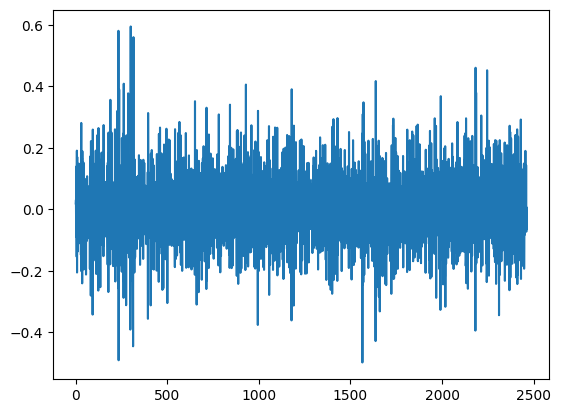

In [ ]:
# Plot data
plt.plot(df['hashrate'])
plt.show()

In [ ]:
# Features and target variable
features = ['RMW',
            'ret',
            'Mkt-RF',
            'volume',
            'drxon',
            'spx', 'nasdaq', 'vix',
            'epu', 'gepu',
            'nft', 'cbdc_u', 'cbdc_a',
            'gt_web', 'gt_news',
            'SER', 'active add', 'over10k', 'over100k', 'over1m', 'over1k', 'mean trans fee',
            'total fee', 'miner rev', 'rev per hash', 'hashrate',
            'mean hashrate', 'blox', 'diffic', 'mean diffic', 'inflows', 'outflows',
            'transx', 'transf usd', 'transf']

target = 'ret'

In [ ]:
df.dtypes

Date                      object
RealDate          datetime64[ns]
DateNumber                 int64
RMW                      float64
ret                      float64
Mkt-RF                    object
drxon                      int64
log_vol                  float64
volume                   float64
spx                      float64
nasdaq                   float64
vix                      float64
epu                      float64
gepu                     float64
nft                      float64
cbdc_u                   float64
cbdc_a                   float64
gt_web                   float64
gt_news                  float64
SER                      float64
active add               float64
over10k                  float64
over100k                 float64
over1m                   float64
over1k                   float64
mean trans fee           float64
total fee                float64
miner rev                float64
rev per hash             float64
hashrate                 float64
mean hashr

Skipping column 'RealDate' due to potential overflow issues.


ValueError: Date ordinal -993520.1000000001 converts to -751-10-31T21:35:59.999984 (using epoch 1970-01-01T00:00:00), but Matplotlib dates must be between year 0001 and 9999.

<Figure size 640x480 with 1 Axes>

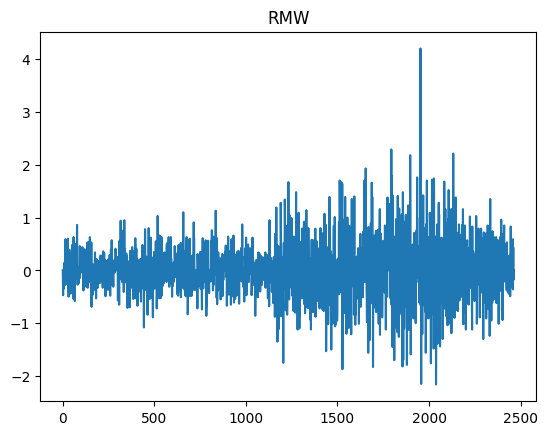

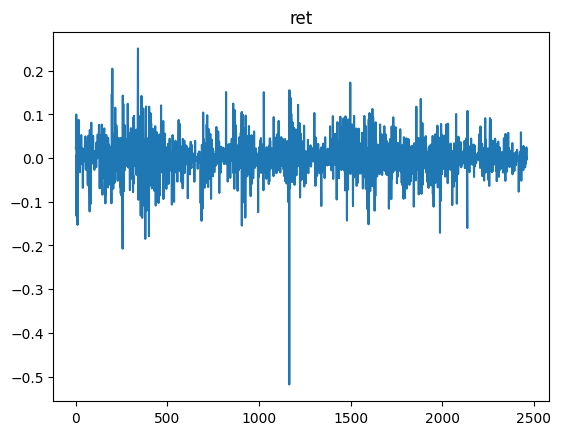

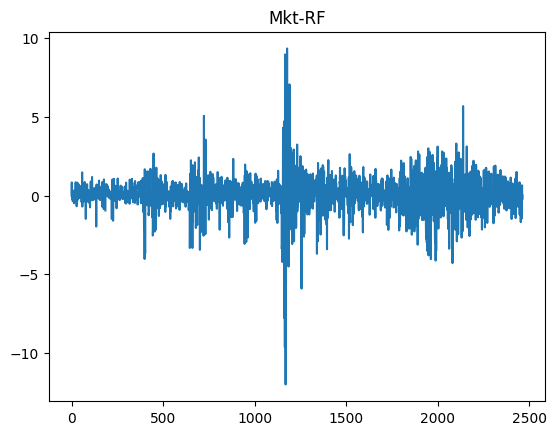

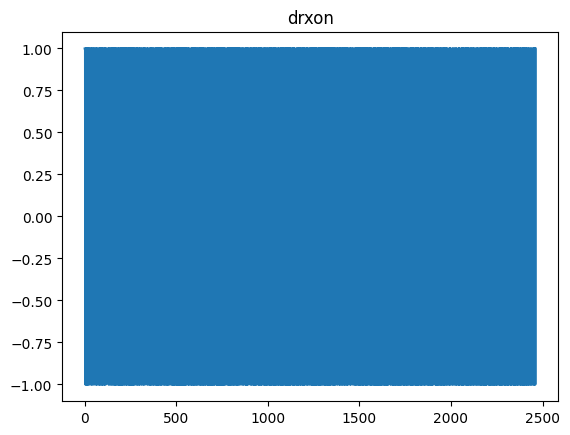

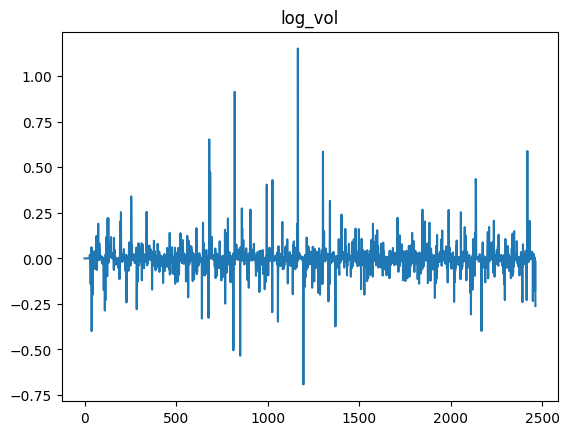

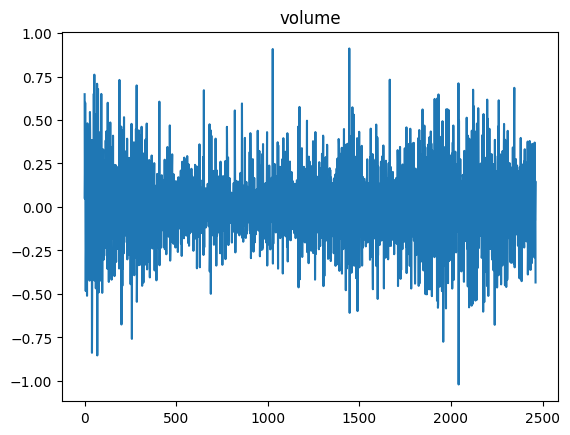

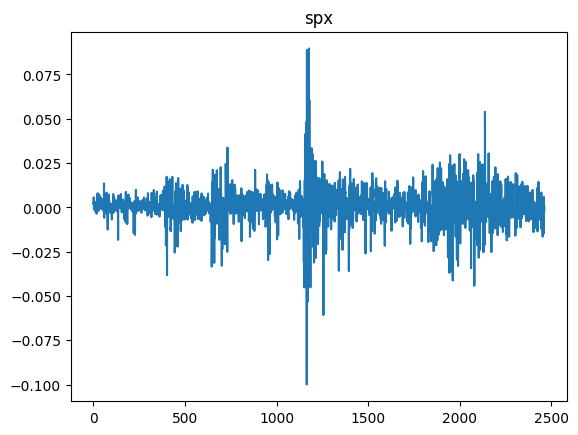

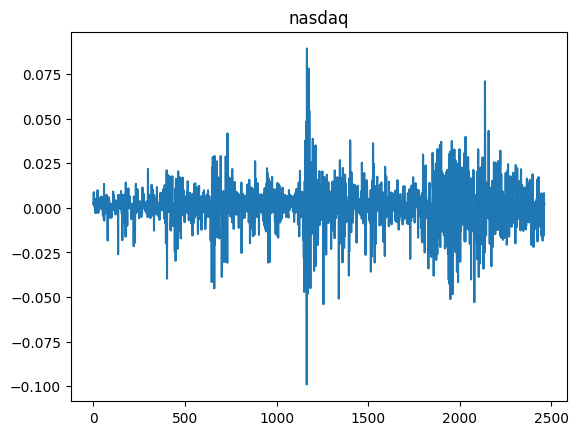

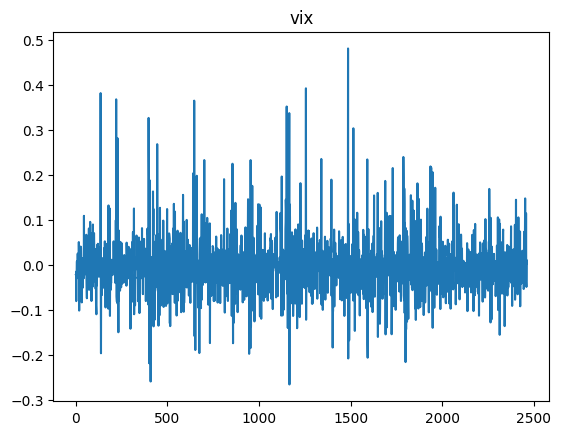

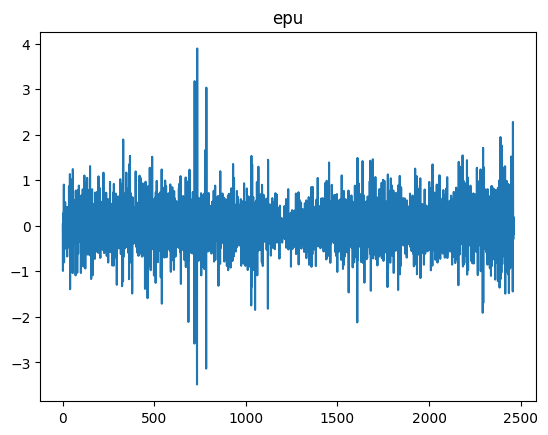

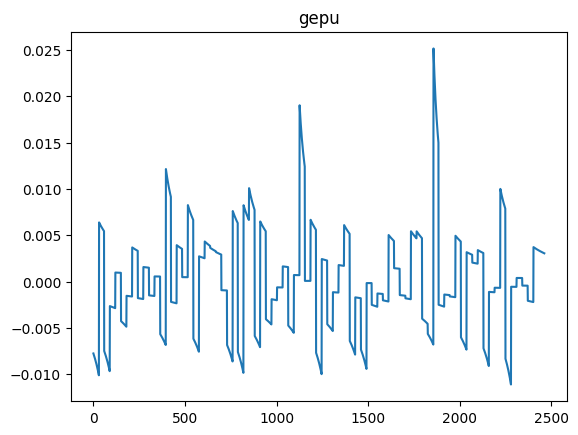

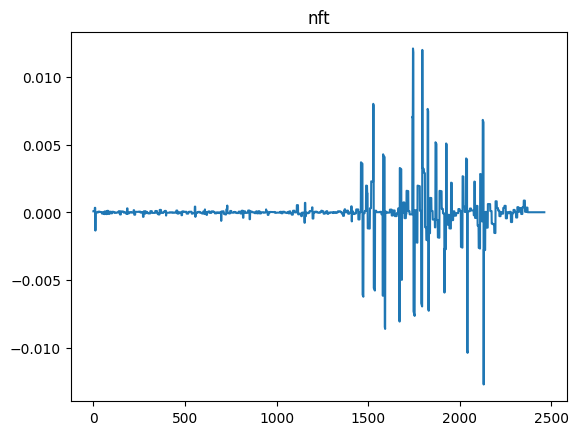

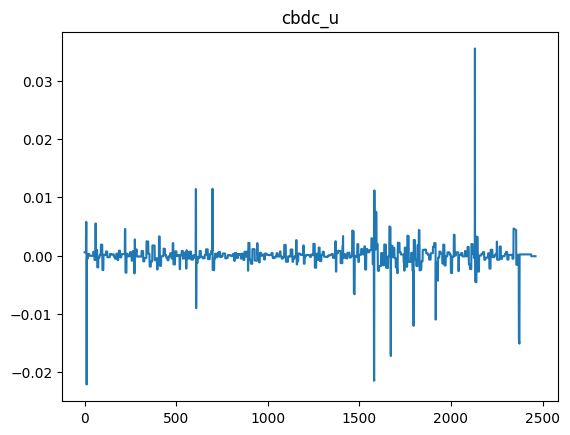

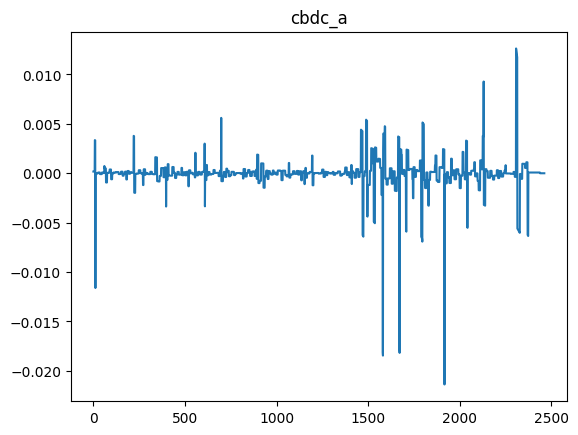

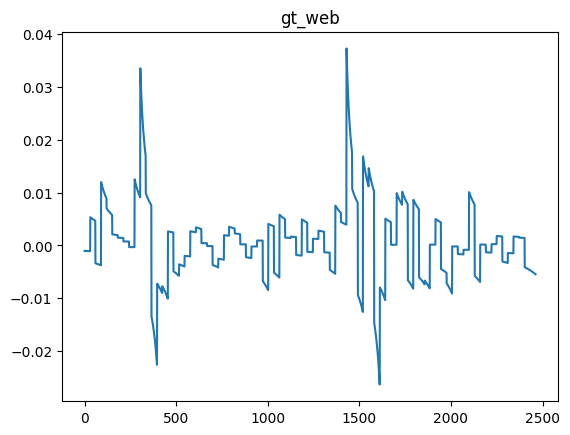

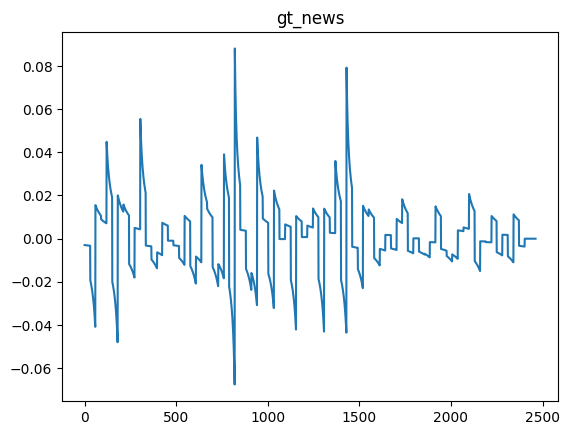

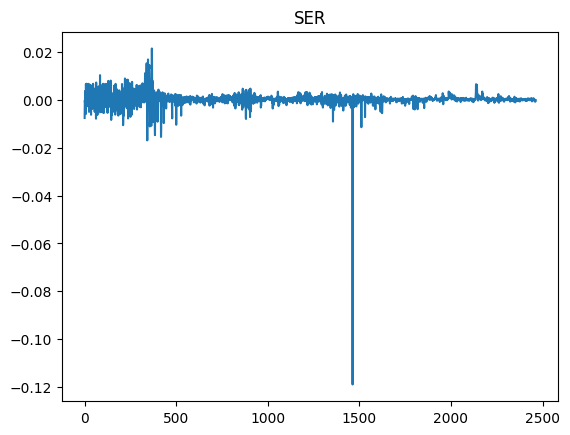

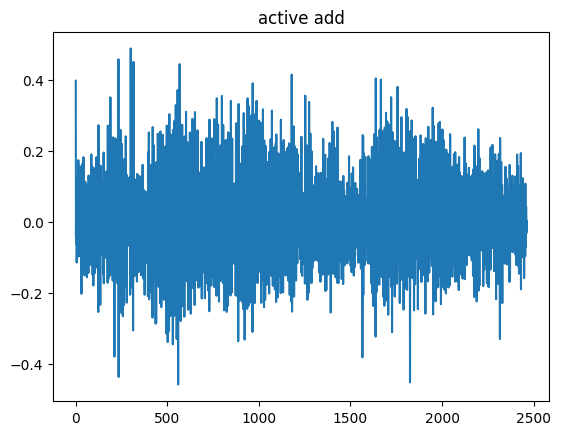

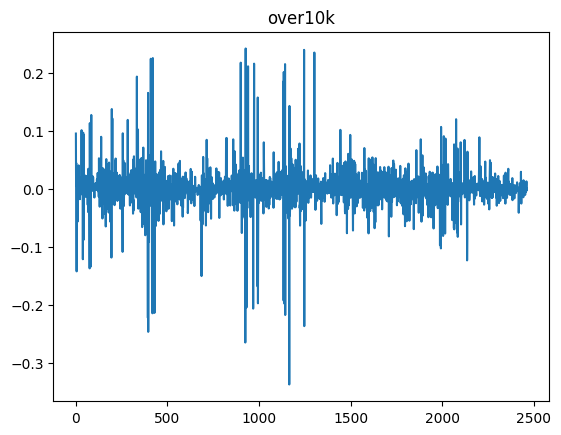

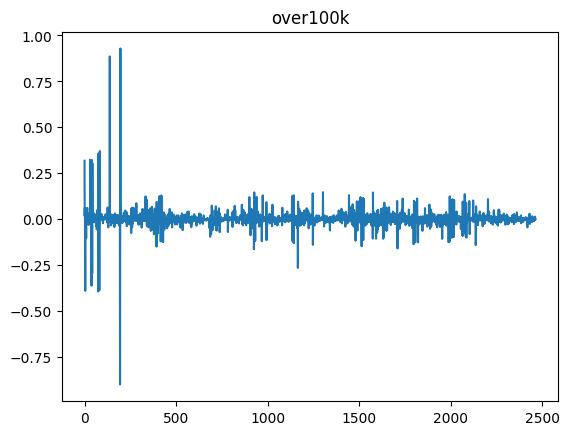

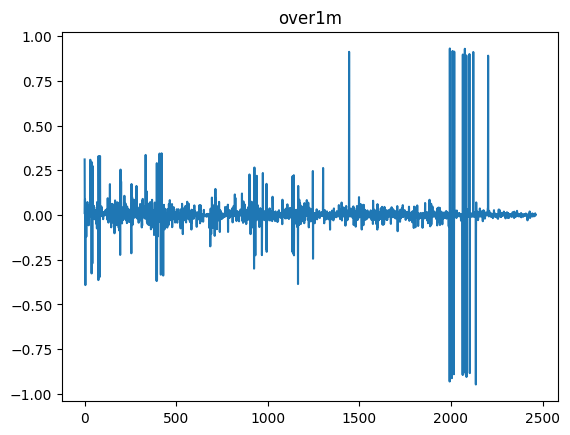

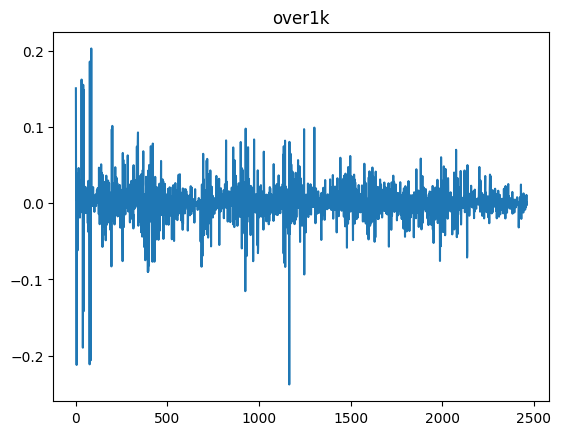

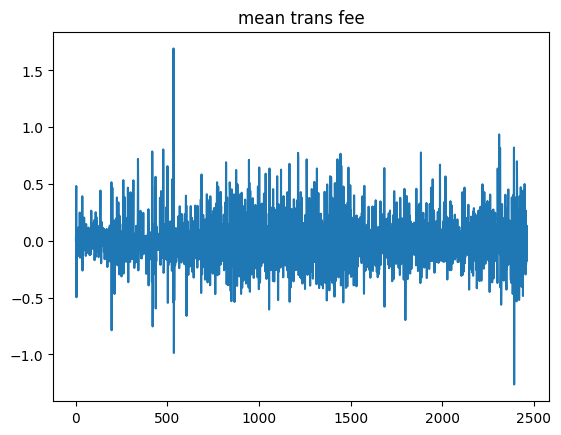

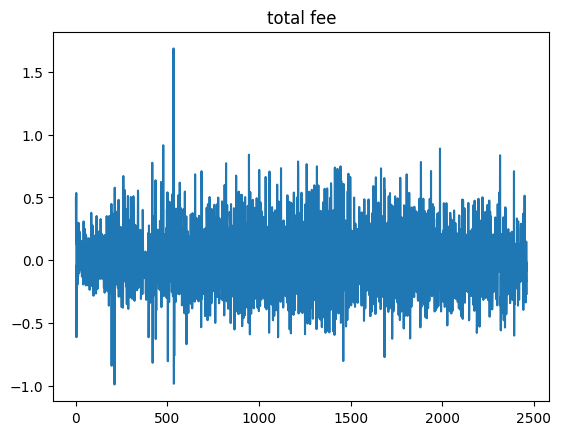

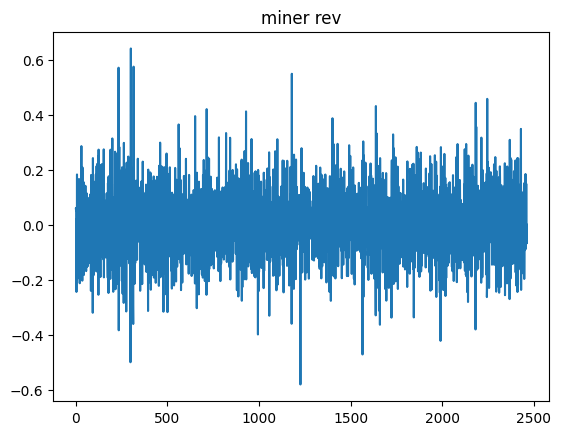

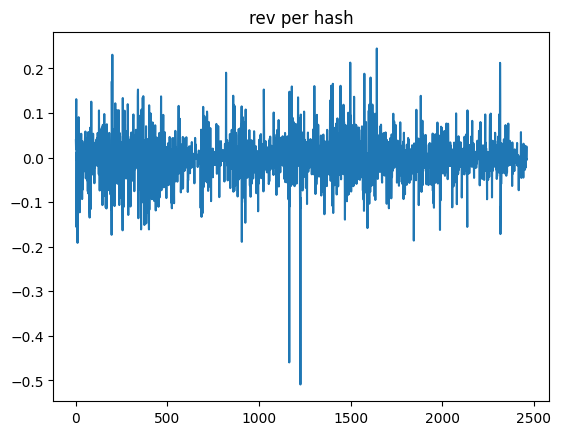

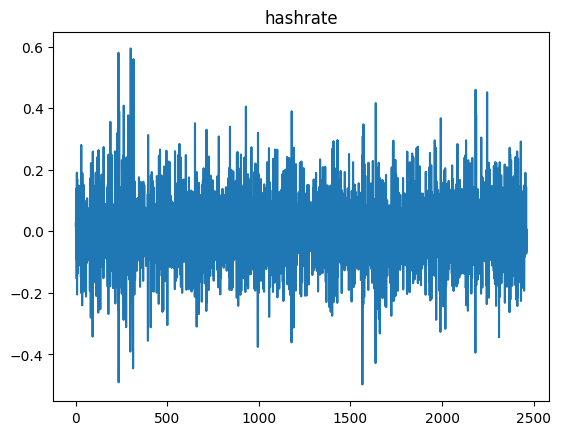

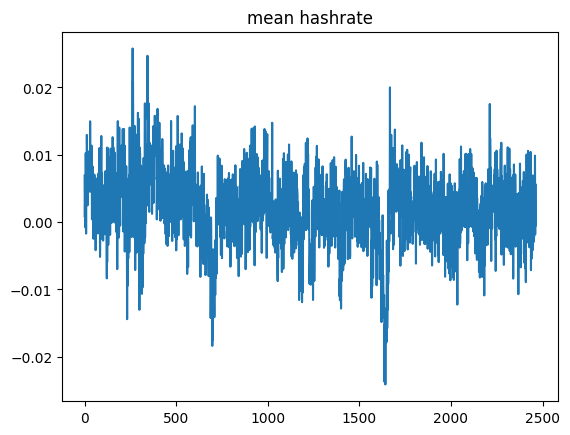

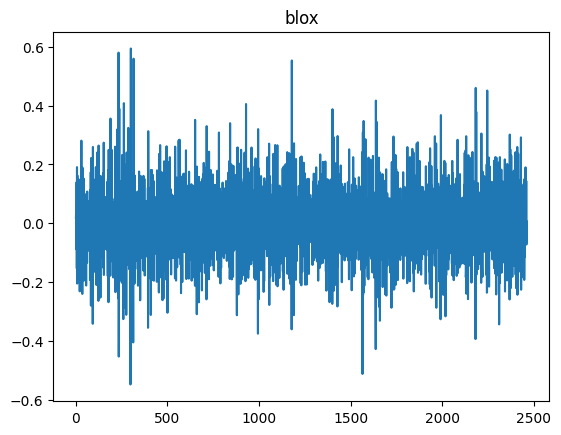

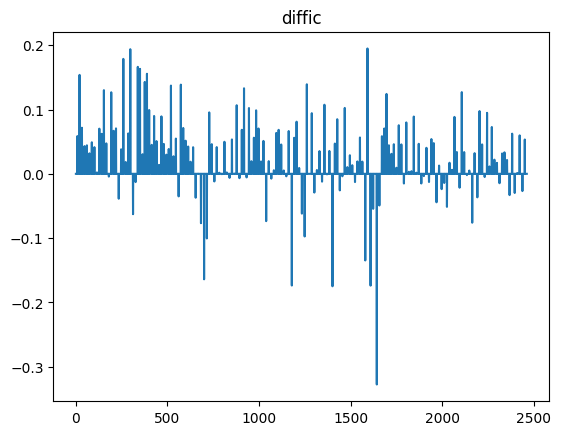

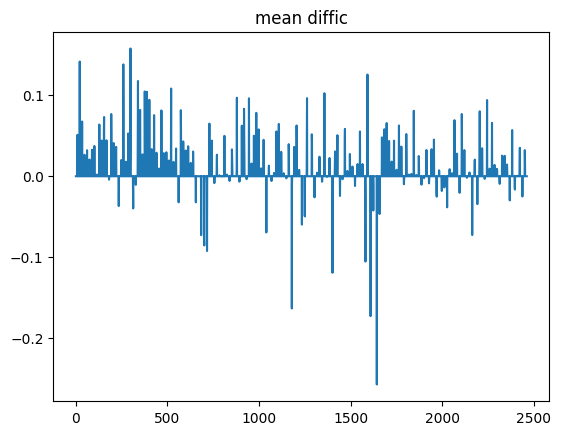

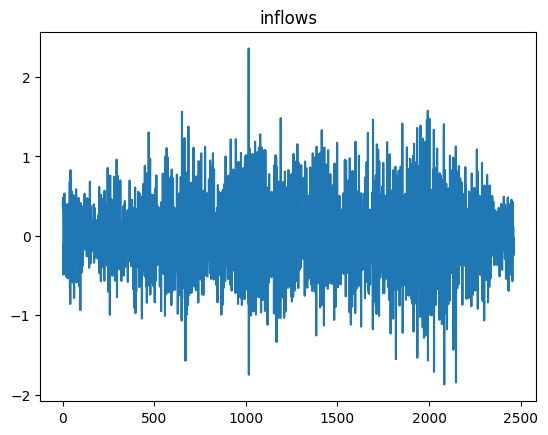

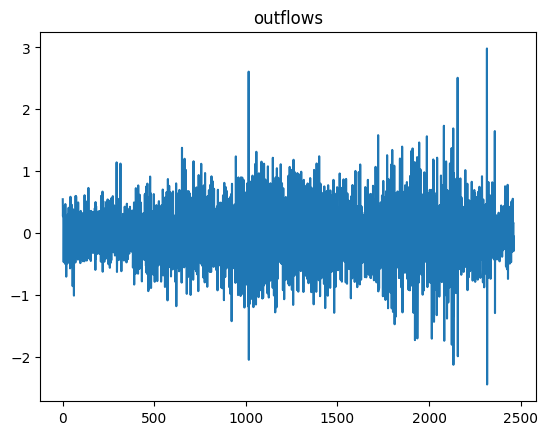

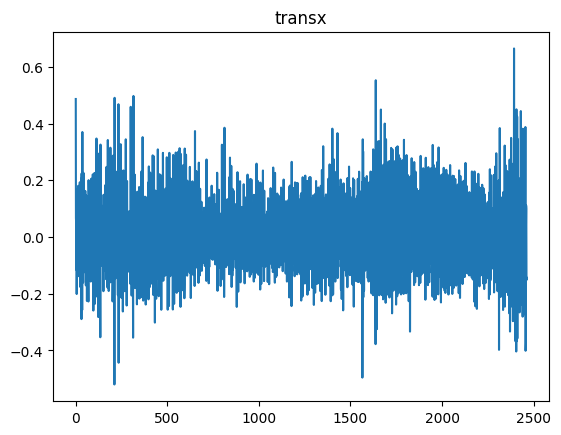

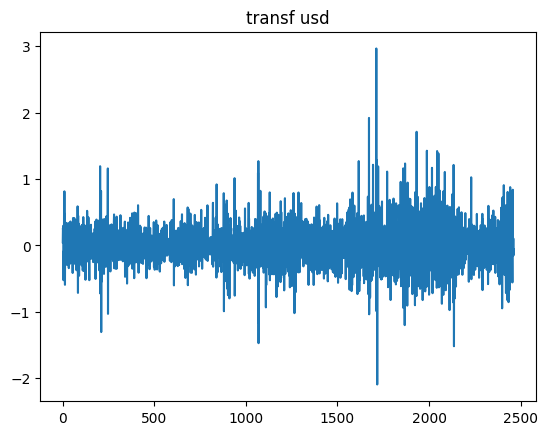

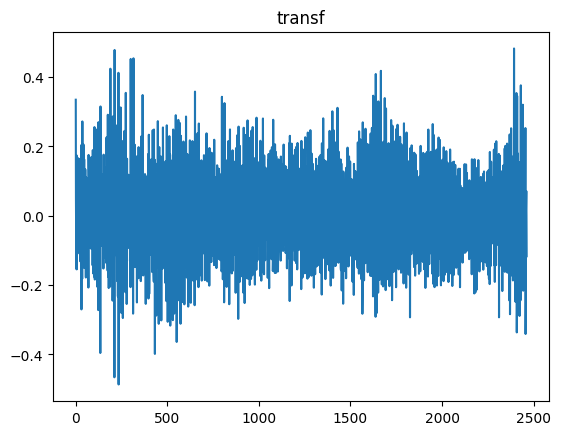

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

for i in df.columns:
  if i == 'Date':  # Handle the 'Date' column differently
    # Convert 'Date' column to datetime objects, assuming the format is 'month/day/year'
    df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
    plt.plot(df['Date'], df[i])  # Plot date on x-axis, values on y-axis
  else:
    # Attempt to convert the column to numeric, handling non-numeric values
    try:
        df[i] = pd.to_numeric(df[i], errors='coerce')  # Non-numeric values will become NaN
        # Check if the column contains excessively large values
        if df[i].max() < 1e10:  # Adjust the threshold as needed
            plt.plot(df[i])
            plt.title(i)
            plt.show()
        else:
            print(f"Skipping column '{i}' due to potential overflow issues.")
    except ValueError:
        print(f"Skipping column '{i}' due to non-numeric values.")

In [ ]:
df.Date

0      2017-02-01
1      2017-03-01
2      2017-04-01
3      2017-05-01
4      2017-06-01
          ...    
2458   2023-09-26
2459   2023-09-27
2460   2023-09-28
2461   2023-09-29
2462   2023-09-30
Name: Date, Length: 2463, dtype: datetime64[ns]

Experiment 1 - Split the training and testing across years
This pipeline is useful to find the baseline scores of our model. We first split the data into training, testing, and validation. Then apply 5 different models to test performance. Once we evaluate these models, we then find the important features.

               Model      Test MSE      Test MAE   Test R2
0  Linear Regression  2.354770e-32  1.194869e-16  1.000000
1   Ridge Regression  1.859995e-09  2.394004e-05  0.999996
2   Lasso Regression  5.183915e-04  1.521160e-02 -0.000500
3      Decision Tree  1.619334e-07  1.278834e-04  0.999687
4      Random Forest  9.013194e-09  4.754937e-05  0.999983


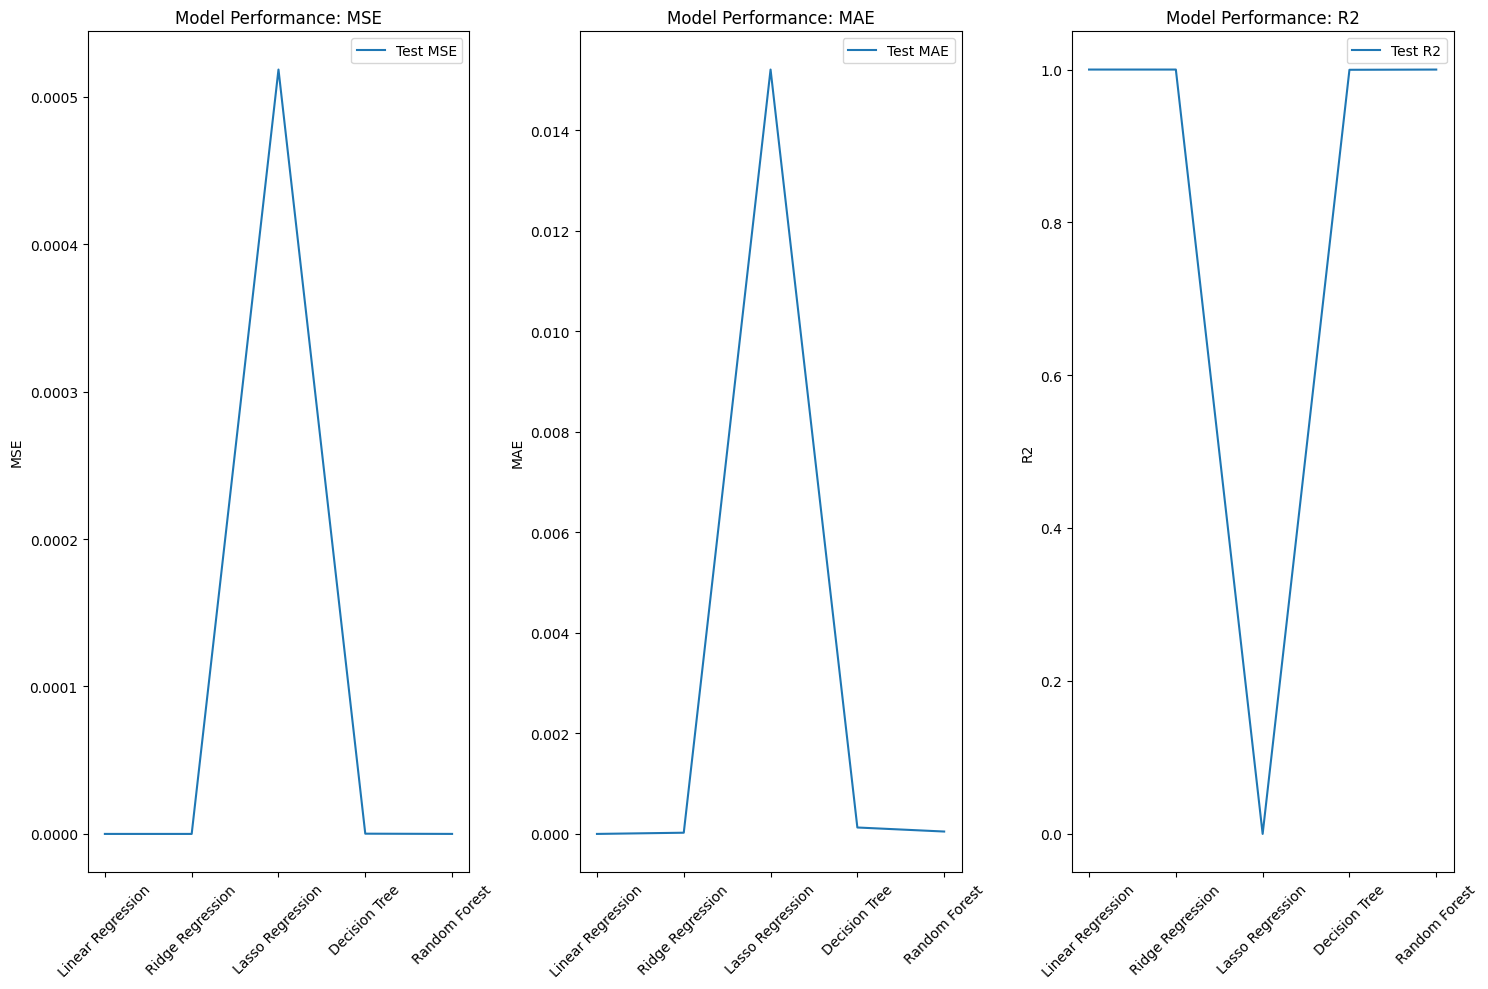

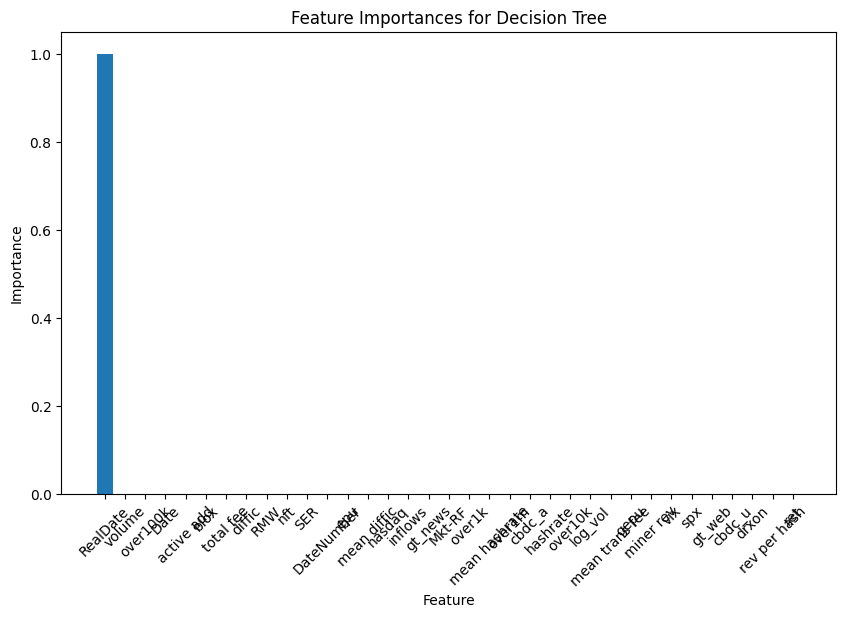

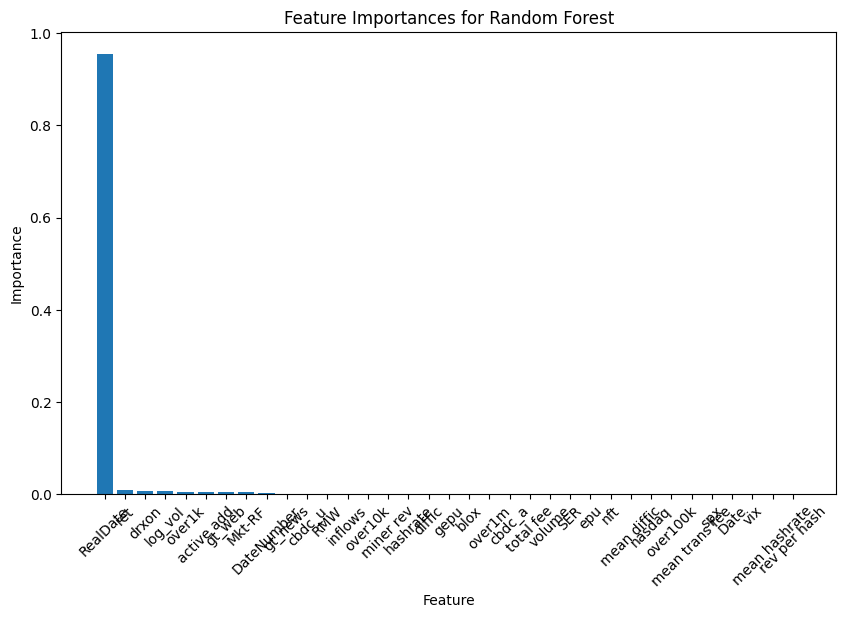

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer # Import SimpleImputer to handle NaN values
from datetime import datetime
from typing import Tuple

column_names = df.columns

# Apply the Scaling and Imputation
imputer = SimpleImputer(strategy='mean') # Create an imputer to fill NaN values with the mean
scaler = StandardScaler()
pipeline = make_pipeline(imputer, scaler) # Create a pipeline to apply imputation and scaling

X_train_scaled = pipeline.fit_transform(X_train) # Fit and transform on training data
X_test_scaled = pipeline.transform(X_test) # Transform test data using the fitted pipeline

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor()
}


def custom_train_test_split(df: pd.DataFrame, cutoff_date: datetime, target_column_name: str) -> Tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.Series]:
    """
    Splits a DataFrame into training and testing sets based on a specified cutoff date.

    This function is designed to segment a dataset for time-series analysis, where the integrity
    of the temporal order is crucial. Data points before the cutoff date are used for training,
    while those on or after this date are reserved for testing. This method ensures that the
    testing data simulates a future period relative to the training data.

    Parameters:
    - df (pd.DataFrame): The complete dataset containing both features and the target variable.
    - cutoff_date (datetime): The date used to split the data. Data up to this date are included
      in the training set, while data from this date onwards are in the testing set.
    - target_column_name (str): The name of the target variable column in the dataset.

    Returns:
    - Tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.Series]: A tuple containing four elements:
      X_train (DataFrame), y_train (Series), X_test (DataFrame), and y_test (Series).
      X_train and X_test contain the features, while y_train and y_test contain the target variable.
    """
    df['Date'] = pd.to_datetime(df['Date'])
    train_data = df[df['Date'] < cutoff_date].reset_index(drop=True)
    test_data = df[df['Date'] >= cutoff_date].reset_index(drop=True)

    X_train = train_data[features]  # Ensure 'Date' is not in 'features'
    y_train = train_data[target_column_name]
    X_test = test_data[features]  # Ensure 'Date' is not in 'features'
    y_test = test_data[target_column_name]

    return X_train, y_train, X_test, y_test

# Define the cutoff date for splitting data
cutoff_date = datetime(2023, 1, 1)

# Split the data
X_train, y_train, X_test, y_test = custom_train_test_split(
    df=df,
    cutoff_date=cutoff_date,
    target_column_name=target
)

# Apply Imputation and Scaling in the correct order
imputer = SimpleImputer(strategy='mean') # Create an imputer to fill NaN values with the mean
scaler = StandardScaler()
pipeline = make_pipeline(imputer, scaler) # Create a pipeline to apply imputation and THEN scaling

X_train_scaled = pipeline.fit_transform(X_train) # Fit and transform on training data
X_test_scaled = pipeline.transform(X_test) # Transform test data using the fitted pipeline


results = []
feature_importances = {}

# Loop through each model, train it, evaluate, and collect results
for name, model in models.items():
    # Train the model on the training data
    model.fit(X_train_scaled, y_train)

    # Evaluate the model on the test data
    test_predictions = model.predict(X_test_scaled)
    test_mse = mean_squared_error(y_test, test_predictions)
    test_mae = mean_absolute_error(y_test, test_predictions)
    test_r2 = r2_score(y_test, test_predictions)

    # Store the performance metrics for each model
    results.append({'Model': name, 'Test MSE': test_mse, 'Test MAE': test_mae, 'Test R2': test_r2})

    # If the model has feature importances, store them for later use
    if hasattr(model, 'feature_importances_'):
        feature_importances[name] = model.feature_importances_

# Convert the results list into a DataFrame for easier viewing
results_df = pd.DataFrame(results)
print(results_df)

# Plotting performance metrics for each model
metrics = ['MSE', 'MAE', 'R2']
plt.figure(figsize=(15, 10))

for i, metric in enumerate(metrics):
    # Create a subplot for each metric
    plt.subplot(1, 3, i+1)
    plt.plot(results_df['Model'], results_df[f'Test {metric}'], label=f'Test {metric}')
    plt.title(f'Model Performance: {metric}')
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.legend()

plt.tight_layout()
plt.show()

# Plotting feature importances for each model (if available)
for model_name, importances in feature_importances.items():
    # Sort the feature importances in descending order
    indices = np.argsort(importances)[::-1]
    sorted_names = [column_names[i] for i in indices]

    # Create a bar plot for each model's feature importances
    plt.figure(figsize=(10, 6))
    plt.title(f'Feature Importances for {model_name}')
    plt.bar(range(len(importances)), importances[indices], align='center')
    plt.xticks(range(len(importances)), sorted_names, rotation=45)
    plt.ylabel('Importance')
    plt.xlabel('Feature')
    plt.show()

               Model           MSE           MAE        R2
0  Linear Regression  2.354770e-32  1.194869e-16  1.000000
1   Ridge Regression  1.859995e-09  2.394004e-05  0.999996
2   Lasso Regression  5.183915e-04  1.521160e-02 -0.000500
3      Decision Tree  1.568677e-07  1.314649e-04  0.999697
4      Random Forest  6.476128e-09  4.316791e-05  0.999988
5            XGBoost  1.771149e-07  2.521485e-04  0.999658


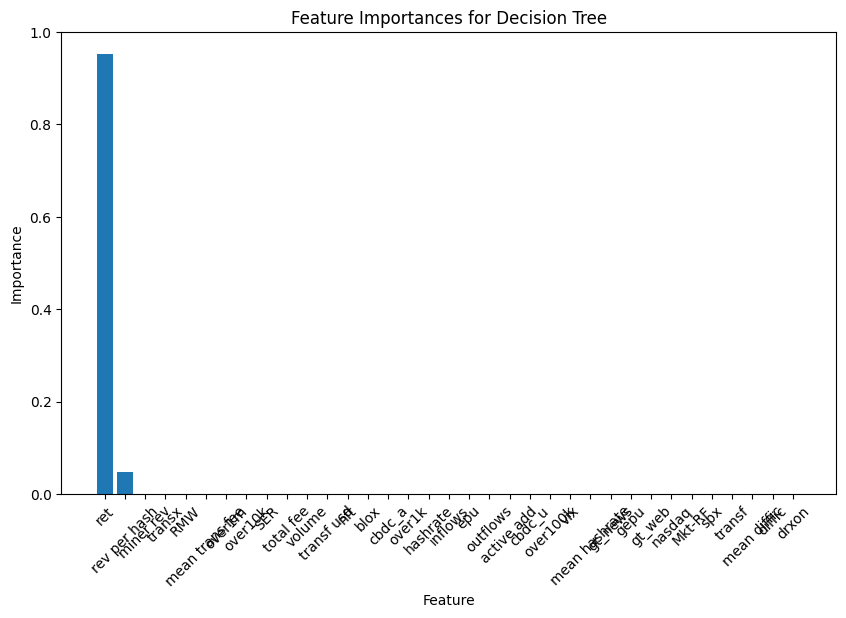

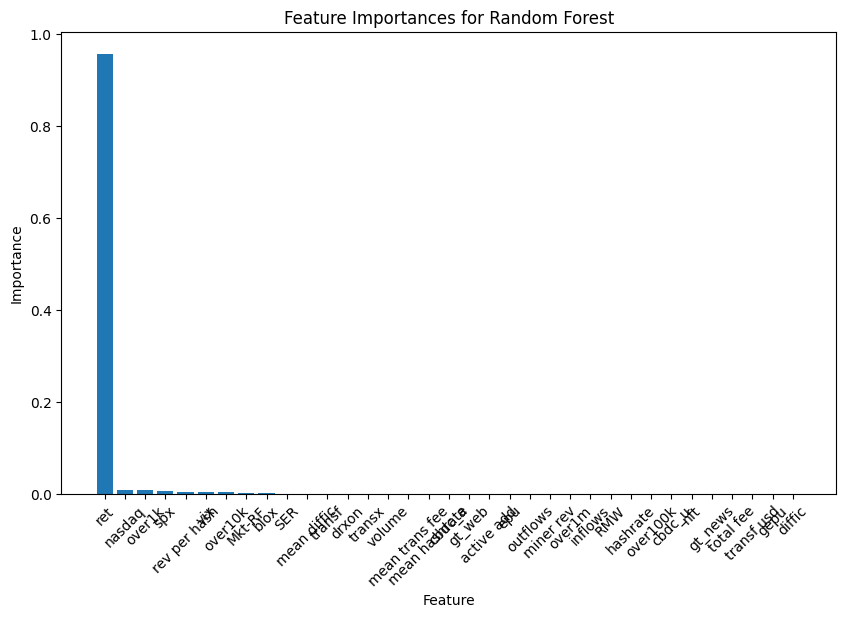

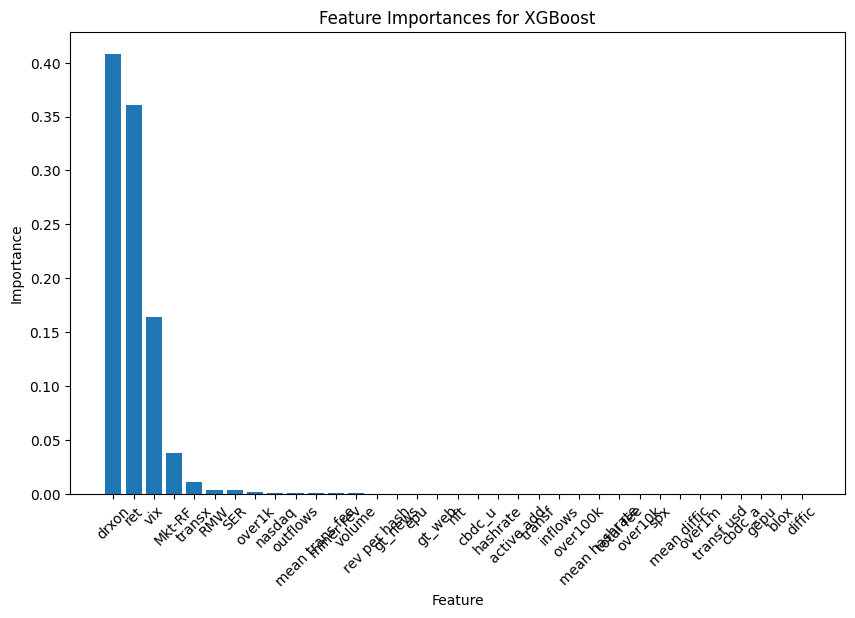

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best parameters for Random Forest: {'n_estimators': 110, 'max_depth': 10}
Best R2 score: 0.9672713186095552


In [21]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Load data
path = '/content/btc_nov20change0F.xlsx'
df = pd.read_excel(path)
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')

# Handle missing values and convert columns to numeric
for col in df.columns:
    if col != 'Date':
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Define features and target variable
features = [
    'RMW', 'ret', 'Mkt-RF', 'volume', 'drxon', 'spx', 'nasdaq', 'vix',
    'epu', 'gepu', 'nft', 'cbdc_u', 'cbdc_a', 'gt_web', 'gt_news',
    'SER', 'active add', 'over10k', 'over100k', 'over1m', 'over1k',
    'mean trans fee', 'total fee', 'miner rev', 'rev per hash', 'hashrate',
    'mean hashrate', 'blox', 'diffic', 'mean diffic', 'inflows', 'outflows',
    'transx', 'transf usd', 'transf'
]
target = 'ret'

# Split the data
cutoff_date = pd.to_datetime('2023-01-01')
train_data = df[df['Date'] < cutoff_date].reset_index(drop=True)
test_data = df[df['Date'] >= cutoff_date].reset_index(drop=True)

X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

# Preprocess data using a pipeline
pipeline = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler())
X_train_scaled = pipeline.fit_transform(X_train)
X_test_scaled = pipeline.transform(X_test)

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'XGBoost': XGBRegressor()
}

# Train and evaluate models
results = []
feature_importances = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    predictions = model.predict(X_test_scaled)

    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    results.append({'Model': name, 'MSE': mse, 'MAE': mae, 'R2': r2})

    if hasattr(model, 'feature_importances_'):
        feature_importances[name] = model.feature_importances_

results_df = pd.DataFrame(results)
print(results_df)

# Plot feature importances
for name, importances in feature_importances.items():
    indices = np.argsort(importances)[::-1]
    sorted_names = [features[i] for i in indices]

    plt.figure(figsize=(10, 6))
    plt.title(f'Feature Importances for {name}')
    plt.bar(range(len(importances)), importances[indices], align='center')
    plt.xticks(range(len(importances)), sorted_names, rotation=45)
    plt.ylabel('Importance')
    plt.xlabel('Feature')
    plt.show()

# Hyperparameter tuning (example for Random Forest)
param_grid = {
    'n_estimators': range(10, 210, 10),
    'max_depth': range(3, 11)
}
rf = RandomForestRegressor()
grid_search = RandomizedSearchCV(rf, param_grid, n_iter=50, scoring='r2', cv=5, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

print(f"Best parameters for Random Forest: {grid_search.best_params_}")
print(f"Best R2 score: {grid_search.best_score_}")
